# Load Face Recognizer CNN model

Download & Create necessary functions

In [ ]:
!pip install pyyaml h5py

from tensorflow.keras.models import load_model
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow((1 - y_pred), gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

Mounted at /content/drive


In [ ]:
import numpy as np

label_train = np.load('/content/drive/MyDrive/saved_model/labels.npy', allow_pickle=True)
model = load_model('/content/drive/MyDrive/saved_model/test_model_new.h5', custom_objects={'focal_loss_fixed': focal_loss})

# Load Face Detection YOLO model

Download & Create necessary functions

In [ ]:
!pip install pillow

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import time

import cv2
import numpy as np
import os
import shutil

from google.colab import files
from google.colab.patches import cv2_imshow

def draw_corner_rect(img, bbox, line_length=30, line_thickness=5, rect_thickness=1,
                     rect_color=(255, 0, 255), line_color=(0, 255, 0)):
    x, y, w, h = bbox
    x1, y1 = x + w, y + h

    if rect_thickness != 0:
        cv2.rectangle(img, bbox, rect_color, rect_thickness)

    # Top Left  x, y
    cv2.line(img, (x, y), (x + line_length, y), line_color, line_thickness)
    cv2.line(img, (x, y), (x, y + line_length), line_color, line_thickness)

    # Top Right  x1, y
    cv2.line(img, (x1, y), (x1 - line_length, y), line_color, line_thickness)
    cv2.line(img, (x1, y), (x1, y + line_length), line_color, line_thickness)

    # Bottom Left  x, y1
    cv2.line(img, (x, y1), (x + line_length, y1), line_color, line_thickness)
    cv2.line(img, (x, y1), (x, y1 - line_length), line_color, line_thickness)

    # Bottom Right  x1, y1
    cv2.line(img, (x1, y1), (x1 - line_length, y1), line_color, line_thickness)
    cv2.line(img, (x1, y1), (x1, y1 - line_length), line_color, line_thickness)

    return img

def draw_face_box(img, coord, rect_color = (255,0,255), line_color = (0,255,0)):
  cropped_img = []

  for det in coord:
    bbox = det[:4]
    x1, y1, x2, y2 = map(int, bbox)

    img = np.array(img)
    cropped_img.append(img[y1:y2, x1:x2])
    img = draw_corner_rect(img, (x1, y1, x2 - x1, y2 - y1), line_length=15, line_thickness=3, rect_thickness=1, rect_color=rect_color, line_color=line_color)

  return img, cropped_img

def face_detect(img, facial_model):
  output = facial_model(img)
  facial_results = Detections.from_ultralytics(output[0])

  # Reshape confidence array to match the shape of xyxy along axis 1
  confidence_array = facial_results.confidence.reshape(-1, 1)  # Convert 1D to 2D with 1 column

  # Concatenate xyxy (bounding boxes) and confidence along axis 1
  facial_list = np.concatenate((facial_results.xyxy, confidence_array), axis=1)

  new_img, persons = draw_face_box(img, facial_list, (255,0,0), (255,0,0))

  return new_img, persons

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  return img

def recognizer(x, model):
  print(type(x))    #list, or
  if type(x) != list:
    x=[x]

  for img in x:
    img_array = np.array(img)
    img_array = img_array.astype('float32')
    print(img_array.shape)

    test_image = img_array     #change this value (numpy image)
    input_image = np.expand_dims(test_image, axis=0)
    sample_result = model.predict(input_image)
    print(sample_result)

    print(label_train)

    if(max(sample_result[0]) > 0.5):
      sample_result = np.argmax(sample_result, axis=1)
      sample_result = int(sample_result[0])

      print(label_train[sample_result])
    else:
      print('unknown')

    cv2_imshow(img_array)

def capture_detection(facial_model):
  img = take_photo()
  print(type(img))
  new_img, persons = face_detect(img, facial_model)

  # Create directory if it doesn't exist
  saving_path = '/content/images'
  os.makedirs(saving_path, exist_ok=True)

  face_size = 200

  for i, person in enumerate(persons):
    timestamp = int(time.time())
    persons[i] = cv2.resize(person, (face_size, face_size))

    filename = f'output_image_{timestamp + i}.jpg'
    cv2.imwrite(os.path.join('/content/images', filename), persons[i])
    cv2_imshow(persons[i])
    #cv2.waitKey(0)

  #cv2.destroyAllWindows()

  cv2_imshow(new_img)

  return persons

In [ ]:
!python --version


Python 3.11.11


In [ ]:
!pip install ultralytics --upgrade
!pip install supervision

# load libraries
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image
from google.colab.patches import cv2_imshow

# download model
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.pt:   0%|          | 0.00/6.25M [00:00<?, ?B/s]

In [ ]:
# load model
facial_model = YOLO(model_path)

### Load a picture and test

In [ ]:
testing_img = '/content/testing.jpg'

if os.path.exists(testing_img):
  image = cv2.imread(testing_img)

  image, persons = face_detect(image, facial_model)
  for i in range(len(persons)):
    persons[i] = cv2.resize(persons[i], (200,200))

  cv2_imshow(image)
  recognizer(persons, model)

# Try with Webcam Screenshot!

<IPython.core.display.Javascript object>

<class 'numpy.ndarray'>

0: 480x640 1 FACE, 478.2ms
Speed: 14.9ms preprocess, 478.2ms inference, 35.2ms postprocess per image at shape (1, 3, 480, 640)


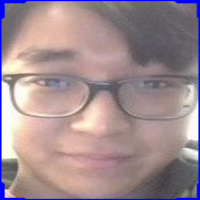

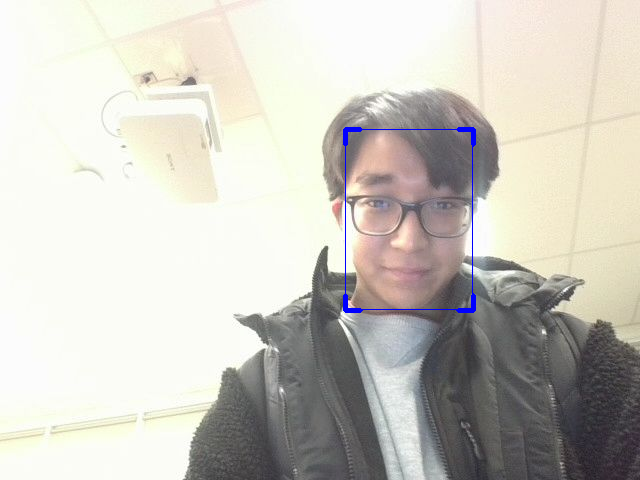

<class 'list'>
(200, 200, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[    0.22274     0.20812    0.034891     0.53425]]
['Jenil' 'Priyatham' 'Taekjin' 'unknown']
unknown


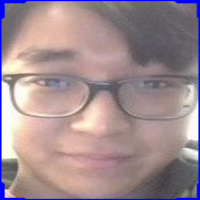

In [ ]:
img = capture_detection(facial_model)
recognizer(img, model)

In [ ]:
from IPython.display import display, Javascript, Image
import PIL
import io
import sys

In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def video_face_detection(facial_model, img):
  #print(type(img))
  face_img = None

  # Create directory if it doesn't exist
  saving_path = '/content/images'
  os.makedirs(saving_path, exist_ok=True)

  detect_list = face_detect(img, facial_model)
  persons, xL1, yL1, xL2, yL2 = crop_img(img, detect_list)

  for i, person in enumerate(persons):
    timestamp = int(time.time())
    persons[i] = cv2.resize(person, (model.input_shape[1], model.input_shape[2]))

    filename = f'output_image_{timestamp + i}.jpg'
    cv2.imwrite(os.path.join('/content/images', filename), persons[i])
    #cv2_imshow(face_img)
    #cv2.waitKey(0)

  #cv2.destroyAllWindows()

  #cv2_imshow(new_img)

  return persons, xL1, yL1, xL2, yL2

def recognizer(imges, model, bbox_array, xL1, yL1, xL2, yL2):
  if type(imges) != list:
    imges=[imges]

  for i, img in enumerate(imges):
    img_array = np.array(img)
    img_array = img_array.astype('float32')

    test_image = img_array     #change this value (numpy image)
    input_image = np.expand_dims(test_image, axis=0)
    sample_result = model.predict(input_image, verbose=False)
    #print(sample_result)

    #print(label_train)
    confidence = max(sample_result[0])

    if(confidence > 0.5):
      sample_result = np.argmax(sample_result, axis=1)
      sample_result = int(sample_result[0])

      #print(label_train[sample_result])
      result = label_train[sample_result]
    else:
      #print('unknown')
      result = 'unknown'

    if result != 'unknown':
      rect_color = (0, 255, 0)    #Green
    else:
      rect_color = (255, 0, 0)    #Red

    #Draw the boxes with labels
    bbox_array = cv2.rectangle(bbox_array, (xL1[i], yL1[i]), (xL2[i], yL2[i]), rect_color, 2)
    bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(result, float(confidence)),
                          (xL1[i], yL1[i]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          (255,255,255), 2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

  # convert overlay of bbox into bytes
  bbox_bytes = bbox_to_bytes(bbox_array)

  return bbox_bytes

In [ ]:
def crop_img(img, coord):
  cropped_img = []
  xL1 = []
  yL1 = []
  xL2 = []
  yL2 = []

  x1 = -100
  y1 = -100
  x2 = -100
  y2 = -100

  for det in coord:
    bbox = det[:4]
    x1, y1, x2, y2 = map(int, bbox)

    img = np.array(img)
    cropped_img.append(img[y1:y2, x1:x2])
    xL1.append(x1)
    yL1.append(y1)
    xL2.append(x2)
    yL2.append(y2)

  return cropped_img, xL1, yL1, xL2, yL2

def face_detect(img, facial_model):
  output = facial_model(img, verbose=False)
  facial_results = Detections.from_ultralytics(output[0])

  # Reshape confidence array to match the shape of xyxy along axis 1
  confidence_array = facial_results.confidence.reshape(-1, 1)  # Convert 1D to 2D with 1 column

  # Concatenate xyxy (bounding boxes) and confidence along axis 1
  facial_list = np.concatenate((facial_results.xyxy, confidence_array), axis=1)

  #new_img, persons, bbox_array, x, y = draw_face_box(img, facial_list, bbox_array, (255,0,0), (255,0,0))

  return facial_list

In [ ]:
video_stream()
label_html = 'Capturing...'
bbox = ''

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
      break

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])
  img, xL1, yL1, xL2, yL2 = video_face_detection(facial_model, frame)
  if img is not None and len(img) > 0:
    bbox = recognizer(img, model, bbox_array, xL1, yL1, xL2, yL2)

<IPython.core.display.Javascript object>